In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 🐦 Downloading the Indian Birds Dataset 📥
Using kagglehub, we’ll download the latest version of the Indian Birds dataset from Kaggle directly into our environment:

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ichhadhari/indian-birds")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/indian-birds


## 🔧 Importing Libraries for Image Classification 🖼️
In this project, we're importing various libraries to help with image processing, data handling, model building, and training. Here's a quick overview of each:

In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

## 🕊️ Creating a Smaller Dataset for Efficient Processing 📂
Since the Indian Birds dataset has nearly **300,000 images**, we're copying only **400 images per category** to reduce computational load. This smaller dataset will allow us to experiment and train models more efficiently on our system.

In [4]:
#### import os
import shutil

# Define paths
source_path = "/kaggle/input/indian-birds/Birds_25/train"  # Original dataset path
destination_path = "/kaggle/working/limited_dataset2"  # Destination for 400 images per folder

# Create destination directory if it doesn't exist
os.makedirs(destination_path, exist_ok=True)

# Iterate over each folder (bird category) in the source path
for folder_name in os.listdir(source_path):
    folder_source_path = os.path.join(source_path, folder_name)
    folder_dest_path = os.path.join(destination_path, folder_name)

    # Ensure we're working with directories only
    if os.path.isdir(folder_source_path):
        os.makedirs(folder_dest_path, exist_ok=True)  # Create destination folder if not exists

        # List all images in the folder
        images = [f for f in os.listdir(folder_source_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

        # Take the first 400 images (or all if fewer than 500 exist)
        for image_name in images[:400]:
            source_image_path = os.path.join(folder_source_path, image_name)
            dest_image_path = os.path.join(folder_dest_path, image_name)

            # Copy the image to the destination folder
            shutil.copy(source_image_path, dest_image_path)

        print(f"Copied {min(400, len(images))} images from {folder_name}")

print("All folders processed successfully!")


Copied 400 images from Common-Rosefinch
Copied 400 images from Asian-Green-Bee-Eater
Copied 400 images from Common-Kingfisher
Copied 400 images from Jungle-Babbler
Copied 400 images from White-Wagtail
Copied 400 images from Indian-Roller
Copied 400 images from Brown-Headed-Barbet
Copied 400 images from Common-Tailorbird
Copied 400 images from Rufous-Treepie
Copied 400 images from White-Breasted-Waterhen
Copied 400 images from Forest-Wagtail
Copied 400 images from Common-Myna
Copied 400 images from Sarus-Crane
Copied 400 images from House-Crow
Copied 400 images from Hoopoe
Copied 400 images from Coppersmith-Barbet
Copied 400 images from Cattle-Egret
Copied 400 images from Indian-Peacock
Copied 400 images from White-Breasted-Kingfisher
Copied 400 images from Gray-Wagtail
Copied 400 images from Ruddy-Shelduck
Copied 400 images from Red-Wattled-Lapwing
Copied 400 images from Indian-Pitta
Copied 400 images from Indian-Grey-Hornbill
Copied 400 images from Northern-Lapwing
All folders process


## 📊 Exploratory Data Analysis (EDA) on limited_dataset2
### 1️⃣ Counting Images per Category
Let's check the distribution of images across each category to ensure the dataset is balanced.



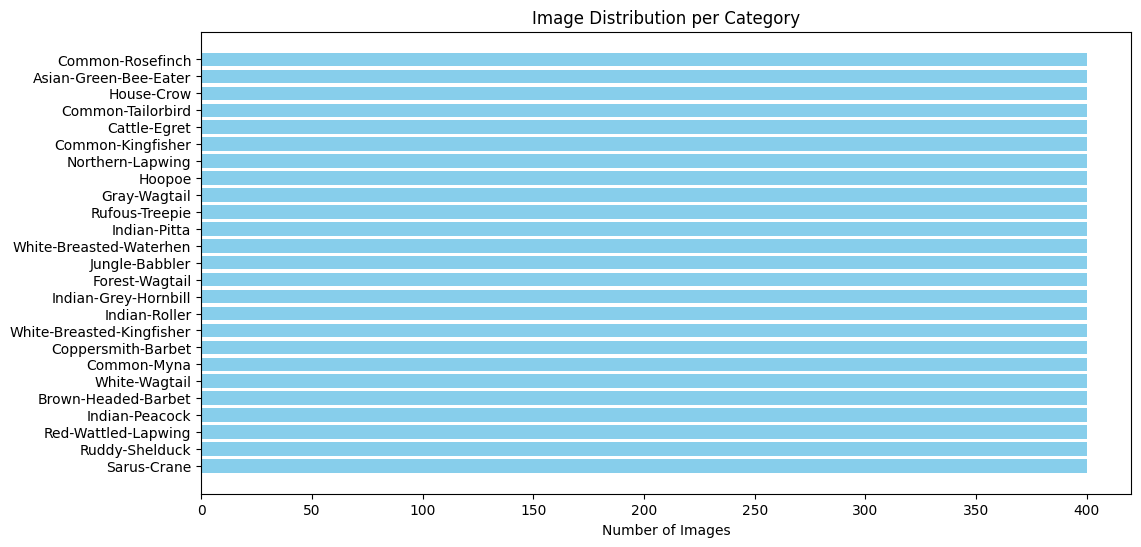

In [17]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Count images in each category
category_counts = {}
for category in os.listdir(destination_path):
    category_path = os.path.join(destination_path, category)
    if os.path.isdir(category_path):
        category_counts[category] = len(os.listdir(category_path))

# Convert to DataFrame for visualization
category_df = pd.DataFrame(list(category_counts.items()), columns=['Category', 'Image Count'])

# Plot the distribution
plt.figure(figsize=(12, 6))
plt.barh(category_df['Category'], category_df['Image Count'], color='skyblue')
plt.xlabel('Number of Images')
plt.title('Image Distribution per Category')
plt.show()


### 2️⃣ Image Dimensions Analysis
Analyzing the dimensions of a few images to verify consistency.

In [18]:
import cv2

# Get dimensions of a sample of images
sample_images = []
for category in os.listdir(destination_path):
    category_path = os.path.join(destination_path, category)
    for image_name in os.listdir(category_path)[:5]:  # Take first 5 images of each category
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            sample_images.append((category, image.shape))

# Convert to DataFrame for better readability
dimensions_df = pd.DataFrame(sample_images, columns=['Category', 'Dimensions'])
dimensions_df['Height'] = dimensions_df['Dimensions'].apply(lambda x: x[0])
dimensions_df['Width'] = dimensions_df['Dimensions'].apply(lambda x: x[1])
dimensions_df.drop(columns=['Dimensions'], inplace=True)

print("Sample image dimensions per category:")
print(dimensions_df.head(10))


Sample image dimensions per category:
         Category  Height  Width
0     Sarus-Crane     927   1200
1     Sarus-Crane     414    620
2     Sarus-Crane     879   1200
3     Sarus-Crane     800   1200
4     Sarus-Crane     927   1200
5  Ruddy-Shelduck     800   1200
6  Ruddy-Shelduck     893   1200
7  Ruddy-Shelduck     782   1200
8  Ruddy-Shelduck     900   1200
9  Ruddy-Shelduck     800   1200


##  3️⃣ Displaying Sample Images from Each Category
To better understand the dataset, let’s visualize a few images from each category.

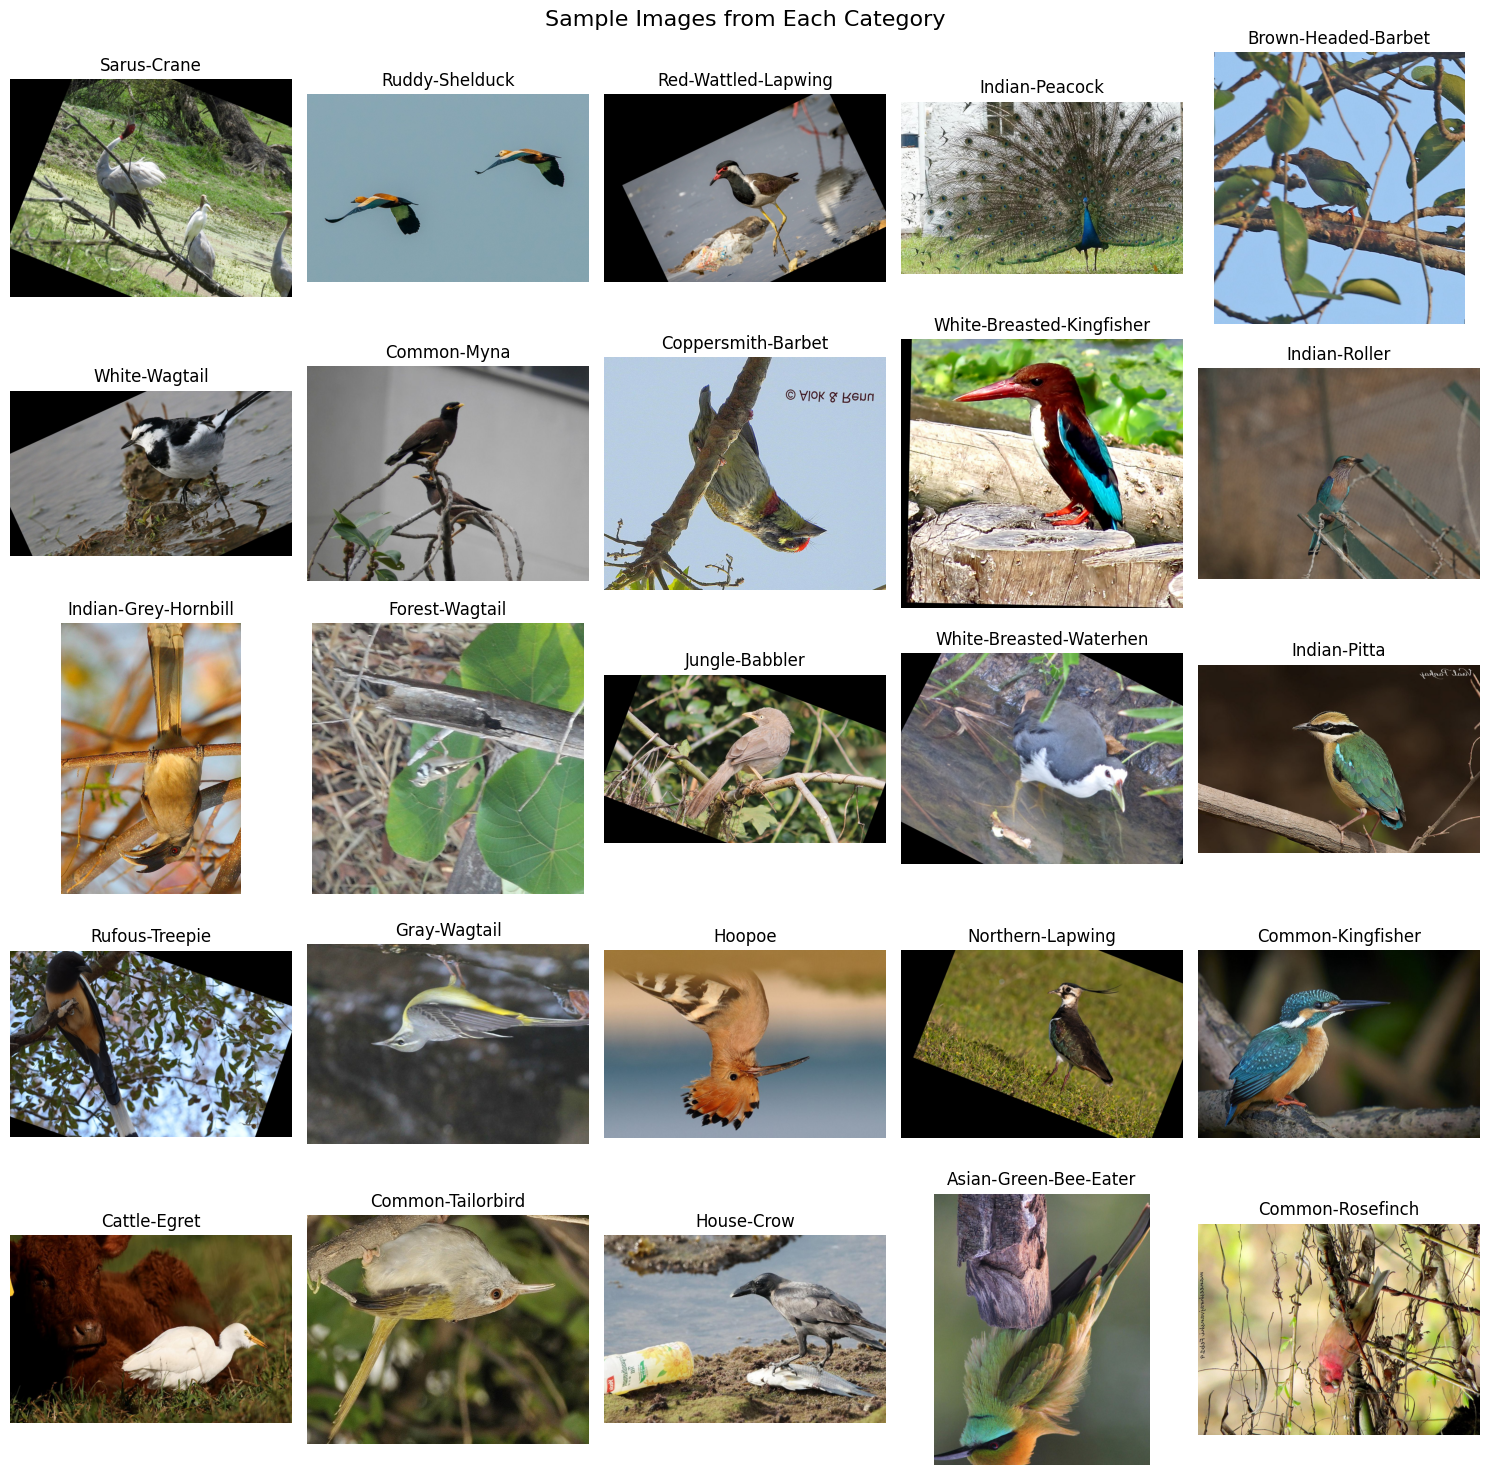

In [19]:
import matplotlib.pyplot as plt
import cv2

# Display a sample image from each category
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle("Sample Images from Each Category", fontsize=16)
axes = axes.flatten()

for i, category in enumerate(os.listdir(destination_path)):
    category_path = os.path.join(destination_path, category)
    image_name = os.listdir(category_path)[0]  # Take the first image of each category
    image_path = os.path.join(category_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title(category)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 🖼️ Preparing Image Data for Training with Augmentation 📊
* **Data Augmentation Setup:** Defined ImageDataGenerator to apply various transformations (e.g., rotation, zoom, flips) for making the model more robust and to prevent overfitting.
* **Training and Validation Split:** Used 80% of images for training and 20% for validation by setting validation_split=0.2.
* **Image Resizing and Scaling:** Resized images to 256x256 pixels and scaled pixel values to a [0,1] range with rescale=1./255 for faster, standardized input.
* **Batching and Class Mode:** Loaded images in batches of 64 with categorical mode for multi-class classification across 25 bird species.

In [14]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator



training_set_path='/kaggle/working/limited_dataset2'

# Define your data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Create training generator
train_generator = train_datagen.flow_from_directory(
    training_set_path,
    target_size=(256, 256),  # Resize images to this size
    batch_size=64,  # Set your batch size
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training',  # Set as training data
    seed=42  # For reproducibility
)

# Create validation generator
validation_generator = train_datagen.flow_from_directory(
    training_set_path,
    target_size=(256, 256),  # Resize images to this size
    batch_size=64,  # Set your batch size
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation',  # Set as validation data
    seed=42  # For reproducibility
)

# Check how many images are in each set
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

Found 8000 images belonging to 25 classes.
Found 2000 images belonging to 25 classes.
Training samples: 8000
Validation samples: 2000


In [1]:
!pip install keras-tuner --quiet


## 🖼️ Preparing Image Data for Training with Augmentation 📊
* **Data Augmentation Setup:** Defined ImageDataGenerator to apply various transformations (e.g., rotation, zoom, flips) for making the model more robust and to prevent overfitting.
* **Training and Validation Split:** Used 80% of images for training and 20% for validation by setting validation_split=0.2.
* **Image Resizing and Scaling:** Resized images to 256x256 pixels and scaled pixel values to a [0,1] range with rescale=1./255 for faster, standardized input.
* **Batching and Class Mode:** Loaded images in batches of 64 with categorical mode for multi-class classification across 25 bird species.

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np

# Path for the test dataset
test_set_path = '/kaggle/input/indian-birds/Birds_25/valid'

# Create ImageDataGenerator for the test set without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Helper function to select 50 random images from each subdirectory
def create_test_generator(test_path, target_size=(224, 224), batch_size=64):
    # Gather all classes (folders)
    classes = os.listdir(test_path)
    selected_files = []

    for cls in classes:
        class_path = os.path.join(test_path, cls)
        # Get all image file paths within the class folder
        image_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
        # Randomly select 50 images from each class
        selected_files.extend(np.random.choice(image_files, 50, replace=False))

    # Create a generator from the selected files
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': selected_files}),
        directory=None,  # No need for a root directory
        x_col='filename',
        y_col=None,  # No labels needed for testing
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )
    
    return test_generator

# Instantiate test generator
test_generator = create_test_generator(test_set_path)




Found 1250 validated image filenames.


In [ ]:
🔍 Hyperparameter Tuning for Bird Classification 🐦
Define Model: A tunable CNN model with 3–5 Conv blocks, variable filters, dropout, and a dense layer.
Setup Tuner: Uses Hyperband with validation accuracy as the objective, tuning over 5 epochs per trial.
Add Callbacks: EarlyStopping stops training early if no improvement is seen.
Run Tuning: Searches for the best hyperparameters with up to 20 epochs.
Get Best Model: Retrieves and displays the best model and hyperparameters.

### 🔍 Hyperparameter Tuning for Bird Classification 🐦
*  **Define Model:** A tunable CNN model with 3–5 Conv blocks, variable filters, dropout, and a dense layer.
*  **Setup Tuner:** Uses Hyperband with validation accuracy as the objective, tuning over 5 epochs per trial.
*  **Add Callbacks:** EarlyStopping stops training early if no improvement is seen.
*  **Run Tuning:** Searches for the best hyperparameters with up to 20 epochs.
*  **Get Best Model:** Retrieves and displays the best model and hyperparameters.

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Define the model-building function with hyperparameters
def build_model(hp):
    model = tf.keras.Sequential()
    
    # Hyperparameter tuning for each convolutional block
    for i in range(hp.Int('conv_blocks', 3, 5)):  # Number of Conv blocks (3-5)
        filters = hp.Int(f'filters_{i}', 32, 256, step=32)
        model.add(Conv2D(filters, kernel_size=(3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(tf.keras.layers.Activation('relu'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(hp.Float(f'dropout_{i}', 0.3, 0.5, step=0.1)))  # Dropout range 0.3-0.5

    # Fully connected layer with tunable units and dropout
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', 128, 512, step=64), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dropout(hp.Float('dense_dropout', 0.3, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(25, activation='softmax'))

    # Compile the model with a tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,  # Set max epochs for quick testing; adjust based on your time/resources
    factor=3,
    directory='/kaggle/working/hyperparam_tuning',
    project_name='bird_classification_tuning'
)

# Callbacks for early stopping and reducing LR
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Search for best hyperparameters
tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stopping],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Summary of the best model
best_model.summary()
print(f"Best hyperparameters: {best_hyperparameters.values}")


### Model Summary Breakdown 📊
* **Total Parameters:** 12,978,265
* **Trainable Parameters:** 12,977,305
* **Non-trainable Parameters:** 960
#### Key Layers
* **Convolutional Layers:** Extract features with filters (32, 64, 128, 256), followed by Batch Normalization and ReLU activation.
* **Pooling:** MaxPooling2D reduces dimensionality.
* **Dropout:** Regularization to prevent overfitting.
* **Dense Layer:** Fully connected layer (192 units) to learn patterns.
* **Output:** Softmax layer for 25-class classification.

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

def create_model():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation('relu'))  # Activation after normalization
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))  # Dropout from trial

    # Block 2
    model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation('relu'))  # Activation after normalization
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))  # Dropout from trial

    # Block 3
    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))  # Adjusted filter size to 128
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation('relu'))  # Activation after normalization
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))  # Dropout from trial

    # Optional Block 4 (Adding an additional block for deeper learning)
    model.add(Conv2D(256, kernel_size=(3, 3), padding='same'))  # Increased filter size to 256
    model.add(BatchNormalization())  # Added Batch Normalization
    model.add(tf.keras.layers.Activation('relu'))  # Activation after normalization
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))  # Dropout from trial

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dropout(0.3))  # Dropout from trial
    model.add(Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # Fully connected layer

    # Output Layer (assuming 25 classes as per your previous code)
    model.add(Dense(25, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.00050265),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create the model
model = create_model()

# Print the model summary to check output shapes
model.summary()




/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 192)            │    12,583,10

 Total params: 12,978,265 (49.51 MB)

 Trainable params: 12,977,305 (49.50 MB)

 Non-trainable params: 960 (3.75 KB)

##  Optimizing CNN Training for Bird Species Classification with Early Stopping

### Early Stopping Callback:

* **Monitors:** Validation loss (val_loss)
* **Patience:** 10 epochs without improvement before stopping
* **Restore Best Weights:** Enabled to revert to the best model checkpoint

### Training:

* **Epochs:** Set to 30 with early stopping potentially halting earlier if no improvement.
* **Callback:** early_stopping added to the callbacks list for training.

### Model Save:

The trained model is saved to /kaggle/working/bird_species_cnn_model.keras.

In [21]:
# Define Early Stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Adjust patience based on convergence speed
    restore_best_weights=True
)

# Train the model with the new setup
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stopping],  # Add early stopping
    verbose=1
)

# Save the model
model.save('/kaggle/working/bird_species_cnn_model.keras')


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.0495 - loss: 12.8418 - val_accuracy: 0.0400 - val_loss: 3.6246
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.0433 - loss: 3.6075 - val_accuracy: 0.0400 - val_loss: 3.5596
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.0409 - loss: 3.5484 - val_accuracy: 0.0400 - val_loss: 3.5089
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.0381 - loss: 3.4975 - val_accuracy: 0.0405 - val_loss: 3.4664
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.0346 - loss: 3.4638 - val_accuracy: 0.0400 - val_loss: 3.4377
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.0445 - loss: 3.4305 - val_accuracy: 0.0400 - val_loss: 3.4085
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.0376 - loss: 3.4021 - val_accuracy: 0.0400 - val_loss: 3.3835
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.0346 - loss: 3.3783 - val_acc